## 基于MindSpore的恶性皮肤肿瘤识别

## 1 实验介绍

本实验旨在使用MindSpore框架在包含4个类别的数据集上，进行模型微调以训练ResNet50模型，实现皮肤病识别模型；

我们将利用MindSpore model_zoo中提供的ResNet50模型定义，通过昇思大模型平台进行模型的训练和优化；

### 1.1 实验目标
1. 掌握使用MindSpore框架进行深度学习模型训练的基本流程；
2. 理解ResNet50模型结构及其在图像分类任务中的应用；
3. 学习如何针对特定数据集（皮肤病图像）调整和优化模型参数；

### 1.2 使用工具介绍
1. **MindSpore框架**：开源深度学习框架，支持端、边、云多种场景，旨在为用户提供全场景AI解决方案；
2. **ResNet50模型**：深度残差网络，通过引入残差学习解决了深度网络训练中的梯度消失问题，是图像识别领域广泛使用的模型之一；
3. **昇思大模型平台**：一个基于昇思Mindspore的深度学习平台，提供强大的计算资源和丰富的模型库；

### 1.3 实验步骤
1. **数据准备**：收集并预处理皮肤病图像数据集，确保数据质量满足训练需求。
2. **模型选择**：使用MindSpore model_zoo中的ResNet50模型作为基础模型。
3. **模型训练**：在昇思大模型平台上配置训练参数，启动模型训练过程。
4. **性能评估**：通过验证集评估模型性能，调整超参数以优化模型。
5. **模型部署**：将训练好的模型部署到实际应用中，进行皮肤病识别。

### 1.4 预备知识
1. 熟练使用Python，了解Shell及Linux操作系统基本知识；
2. 具备一定的深度学习理论知识，如卷积神经网络、损失函数、优化器，训练策略、Checkpoint等；
3. 了解并熟悉MindSpore AI框架，MindSpore官网：https://www.mindspore.cn/

In [1]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.4.10，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.4.10
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.4.10
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: mindnlp


## 2 数据集处理

### 2.1 数据集介绍

数据集共有四类皮肤图片，分别为Basal Cell Carcinoma（基底细胞癌）、Melanoma（黑色素瘤）、Pigmented Benign Keratosis（色素性良性角化病）、Nevus（痣）四种；

- 基底细胞癌：是一种常见的皮肤癌，起源于表皮的基底细胞层，通常不会转移到身体其他部位，但如果不治疗，可能会局部侵袭并破坏周围组织；
- 黑色素瘤：是一种较为严重的皮肤癌，起源于皮肤中的黑色素细胞，可以迅速扩散到身体其他部位，因此早期发现和治疗至关重要；
- 痣：为色素痣，是皮肤上的一种色素沉着区域，通常为良性，可以是先天性的，也可以是后天发展的；
- 色素性良性角化病：是一种良性皮肤病变，表现为皮肤上的小色素斑块，通常不会引起健康问题，但有时可能会被误认为是黑色素瘤；

### 2.2 数据集获取和整理

数据集这里已经上传到昇思大模型社区内，链接为：https://xihe.mindspore.cn/datasets/knoka/pifudata_Maker/tree

这里可以用git快速获取，下载后存储在pifudata_Maker文件夹内

In [3]:
!git clone https://source-xihe-mindspore.osinfra.cn/knoka/pifudata_Maker.git

正克隆到 'pifudata_Maker'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 0
接收对象中: 100% (12/12), 462.96 MiB | 14.91 MiB/s, 完成.


In [4]:
%%capture captured_output
# 解压数据集pifudata_Maker/skin-cancer-detection.tar 并存储到pifudata_Maker文件夹内
!tar -xv -f pifudata_Maker/skin-cancer-detection.tar -C pifudata_Maker/

下载后可以看到我们的数据集为如下形式，其中`dataset_dir`  根目录名称可以根据需要进行更改。

训练图像目录
`train`  包含用于训练的各个皮肤图像类别的目录
- `class1`
- `class2`
- `class3`
- `class4`

验证图像目录
`val`  包含用于验证的各个皮瘤图像类别的目录
- `class1`
- `class2`
- `class3`
- `class4`

下面部分代码则是将文件夹英文名转为数字0-3命名，至于为什么为这种格式，则源由于图像分类任务通常为将数据集组织成文件夹，其中每个文件夹的名称代表一个类别；

因此会期望每个文件夹名称是一个可以识别的标签，如果文件夹名称是数字，则可以将其直接作为类别标签，因为在训练过程中模型需要将输入数据（图像）与输出标签（类别）关联起来；

将疾病名称重命名为对应的编号后，MindSpore提供一种简便的方式来加载和处理数据集，即通过文件夹名称自动将图片分配到对应的类别；因此确保数据集的转换如此，可以简化数据加载和处理过程，直接使用文件夹名称（即编号）作为图像的标签，而不需要额外的映射步骤。


In [5]:
import os

# 定义疾病名称和编号的映射
diseases = {
    0: "basal_cell_carcinoma",
    1: "melanoma",
    2: "nevus",
    3: "pigmented_benign_keratosis",
}

# 定义目标文件夹路径
target_directory = "pifudata_Maker/images/"  # 替换为你的文件夹路径

# 遍历每个疾病名称和编号
for folder in ["train", "val"]:
    folder_path = os.path.join(target_directory, folder)
    print(folder_path)
    for number,disease in diseases.items():
        # 构造完整的旧文件夹路径
        old_folder_path = os.path.join(folder_path, disease)
        
        # 检查旧文件夹是否存在
        if not os.path.exists(old_folder_path):
            print(f"Folder not found: {old_folder_path}")
            continue
        
        # 构造新的文件夹名称
        new_folder_name = f"{number}"
        
        # 构造完整的新文件夹路径
        new_folder_path = os.path.join(folder_path, new_folder_name)
        
        # 重命名文件夹
        os.rename(old_folder_path, new_folder_path)
        print(f"Renamed {old_folder_path} to {new_folder_path}")

pifudata_Maker/images/train
Renamed pifudata_Maker/images/train/basal_cell_carcinoma to pifudata_Maker/images/train/0
Renamed pifudata_Maker/images/train/melanoma to pifudata_Maker/images/train/1
Renamed pifudata_Maker/images/train/nevus to pifudata_Maker/images/train/2
Renamed pifudata_Maker/images/train/pigmented_benign_keratosis to pifudata_Maker/images/train/3
pifudata_Maker/images/val
Renamed pifudata_Maker/images/val/basal_cell_carcinoma to pifudata_Maker/images/val/0
Renamed pifudata_Maker/images/val/melanoma to pifudata_Maker/images/val/1
Renamed pifudata_Maker/images/val/nevus to pifudata_Maker/images/val/2
Renamed pifudata_Maker/images/val/pigmented_benign_keratosis to pifudata_Maker/images/val/3


### 2.3 数据集比例可视化

通过对数据集进行可视化展示，便于对数据进行直观的查看，为后续超参数的设置等做出帮助；

共有Basal Cell Carcinoma（基底细胞癌）、Melanoma（黑色素瘤）、Pigmented Benign Keratosis（色素性良性角化病）、Nevus（痣）四种皮肤；

其中Nevus训练集图片为357张、Melanoma训练集图片为438张、Pigmented Benign Keratosis训练集图片为462张、Basal Cell Carcinoma训练集图片为376张，四者验证集均为16张；


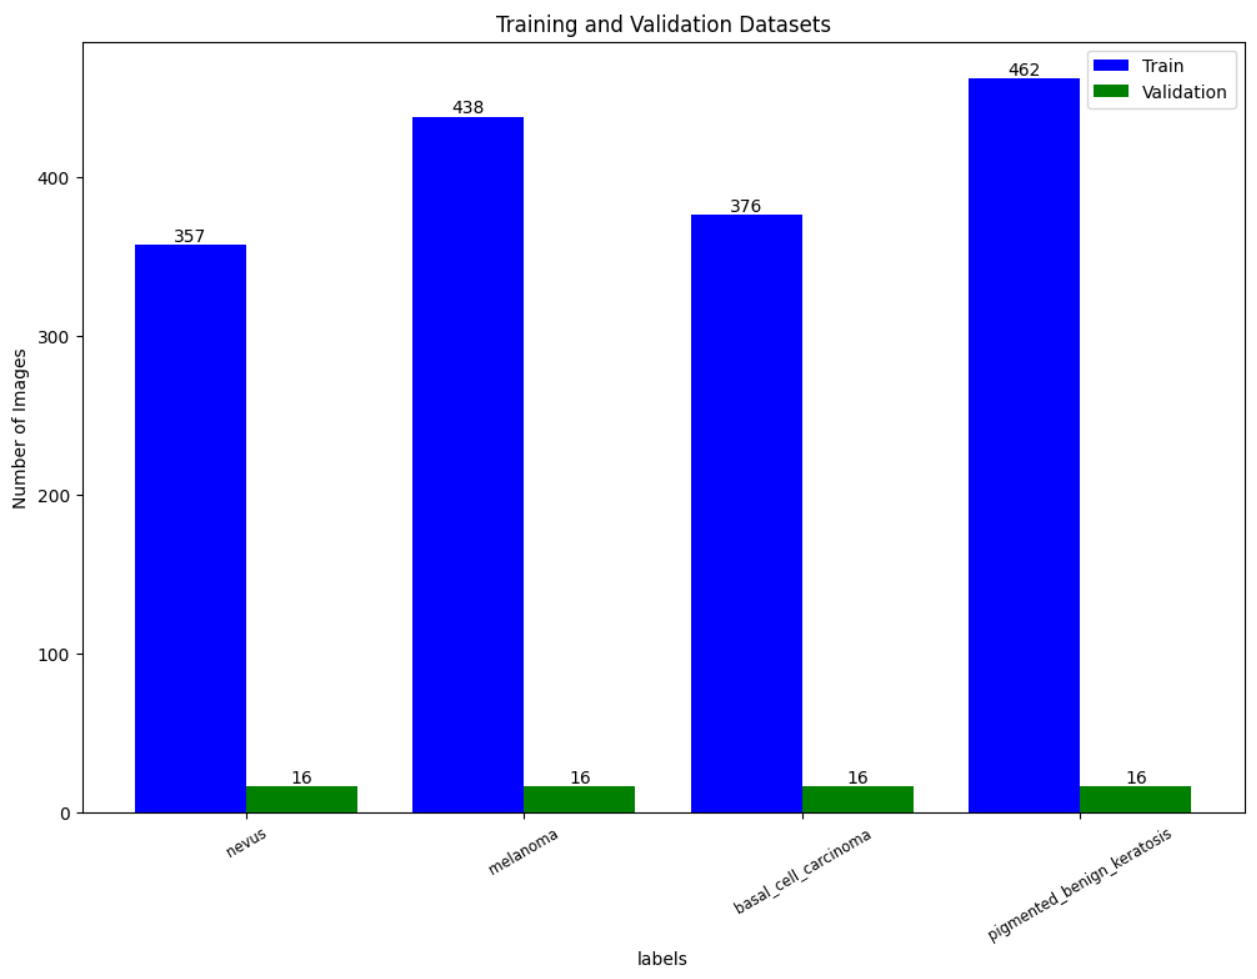

['0', '1', '2', '3']
['basal_cell_carcinoma', 'melanoma', 'nevus', 'pigmented_benign_keratosis']


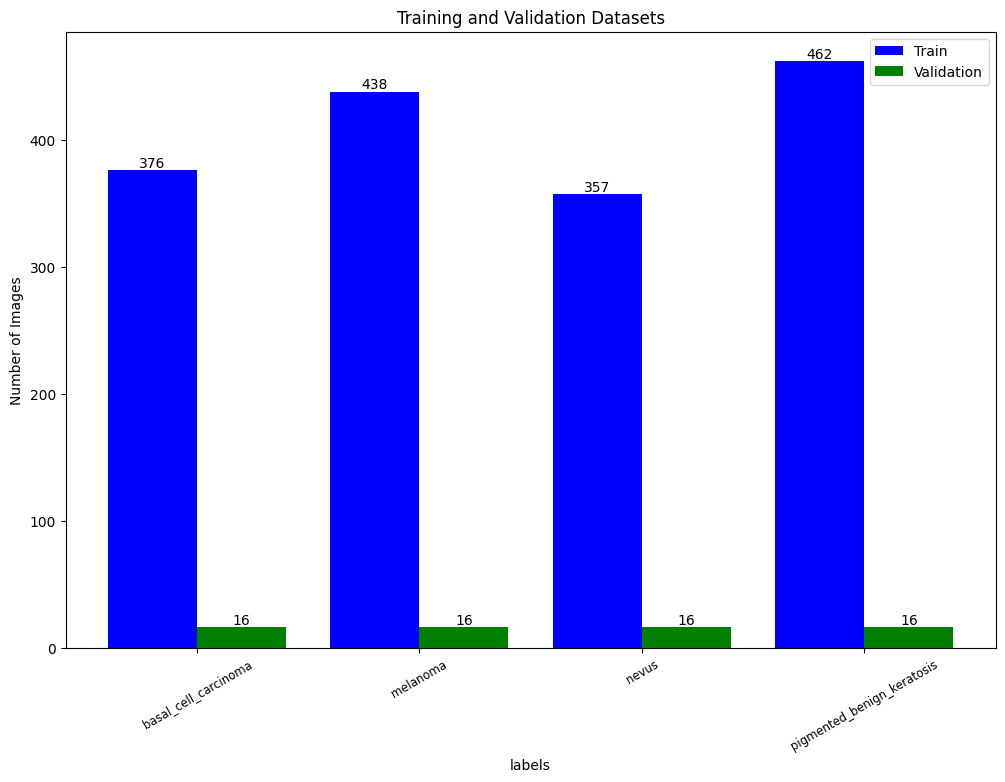

In [6]:
import os
import matplotlib.pyplot as plt

# 疾病编号到名称的映射
diseases = {
    0: "basal_cell_carcinoma",
    1: "melanoma",
    2: "nevus",
    3: "pigmented_benign_keratosis",
}

# 数据集目录路径
data_path_train = "pifudata_Maker/images/train"
data_path_val = "pifudata_Maker/images/val"

# 初始化一个字典来存储每个类别的文件数量
file_counts_train = {}
file_counts_val = {}

# 遍历训练数据文件夹
for folder_name in os.listdir(data_path_train):
    folder_path = os.path.join(data_path_train, folder_name)
    # 确保是文件夹
    if os.path.isdir(folder_path):
        # 计算文件夹内的文件数量
        count = len(os.listdir(folder_path))
        # 使用疾病编号作为字典的键
        file_counts_train[diseases.get(folder_name, folder_name)] = count

# 遍历验证数据文件夹
for folder_name in os.listdir(data_path_val):
    folder_path = os.path.join(data_path_val, folder_name)
    # 确保是文件夹
    if os.path.isdir(folder_path):
        # 计算文件夹内的文件数量
        count = len(os.listdir(folder_path))
        # 使用疾病编号作为字典的键
        file_counts_val[diseases.get(folder_name, folder_name)] = count

# 获取训练集的疾病名称列表
train_categories = list(file_counts_train.keys())

# 使用matplotlib生成条形图
plt.figure(figsize=(12, 8))

# 绘制训练集的条形图
train_bars = plt.bar(train_categories, file_counts_train.values(), width=0.4, color='blue', label='Train')

# 绘制验证集的条形图，错开位置
val_bars = plt.bar([train_categories.index(cat) + 0.4 for cat in train_categories], [file_counts_val.get(cat, 0) for cat in train_categories], width=0.4, color='green', label='Validation')

# 添加图例
plt.legend()

# 使用疾病名称作为X轴标签
plt.xlabel('labels')
plt.ylabel('Number of Images')
plt.title('Training and Validation Datasets')

print(train_categories)

train_list = [diseases[int(i)] for i in train_categories]
print(train_list)

plt.xticks([train_categories.index(cat) + 0.2 for cat in train_categories], [diseases[int(i)] for i in train_categories], rotation=30,fontsize='small')

# 在柱形条上面显示数量
for i, (train_bar, val_bar) in enumerate(zip(train_bars, val_bars)):
    train_height = train_bar.get_height()
    val_height = val_bar.get_height() if val_bar else 0
    plt.text(train_bar.get_x() + train_bar.get_width() / 2, train_height, '{}'.format(train_height), ha='center', va='bottom')
    plt.text(val_bar.get_x() + val_bar.get_width() / 2, val_height, '{}'.format(val_height), ha='center', va='bottom') if val_bar else None

plt.show()

### 2.4 数据加载

 - 使用MindSpore框架的mindspore.dataset模块来加载和预处理图像数据集，以便进行模型训练和验证；
 
 - 定义数据集的路径，并创建了一个函数来加载和应用数据增强操作（如随机裁剪、随机水平翻转等），应用于训练集以提高模型泛化能力，验证集进行简单的解码、调整大小和归一化操作；
 
 - 将图像数据集分批处理，以便于训练过程中的批处理，打印出训练集和验证集的批次数（即数据集大小除以批量大小），并展示验证集中第一个批次图像的张量形状和标签；

In [7]:
# 超参数定义
batch_size = 64                             # 批量大小
image_size = 224                            # 训练图像空间大小
num_epochs = 25                             # 训练周期数
lr = 0.001                                  # 学习率
momentum = 0.6                              # 动量
workers = 4                                 # 并行线程个数
import mindspore
mindspore.set_context(device_target="Ascend")

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [8]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision

# 数据集目录路径
data_path_train = "pifudata_Maker/images/train"
data_path_val = "pifudata_Maker/images/val"

# 创建训练数据集

def create_dataset_canidae(dataset_path, usage):
    """数据加载"""
    data_set = ds.ImageFolderDataset(dataset_path,
                                     num_parallel_workers=workers,
                                     shuffle=True,)
    # 数据增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    scale = 32
    if usage == "train":
        # Define map operations for training dataset
        trans = [
            vision.RandomCropDecodeResize(size=image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            vision.RandomHorizontalFlip(prob=0.5),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]
    else:
        # Define map operations for inference dataset
        trans = [
            vision.Decode(),
            vision.Resize(image_size + scale),
            vision.CenterCrop(image_size),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]

    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)
    # 批量操作
    data_set = data_set.batch(batch_size)
    return data_set


dataset_train = create_dataset_canidae(data_path_train, "train")
step_size_train = dataset_train.get_dataset_size()
dataset_val = create_dataset_canidae(data_path_val, "val")
step_size_val = dataset_val.get_dataset_size()
print(step_size_train)
print(step_size_val)
data = next(dataset_val.create_dict_iterator())
images = data["image"]
labels = data["label"]
# print(data["image"][0])
print("Tensor of image", images.shape)
print("Labels:", labels)

26
1
Tensor of image (64, 3, 224, 224)
Labels: [1 1 3 3 1 3 1 0 0 3 1 2 2 1 2 0 0 0 0 0 0 2 0 2 0 2 2 1 1 2 0 1 3 1 3 0 0
 0 3 1 0 3 3 3 3 0 1 3 3 2 3 2 2 2 2 3 2 1 3 2 1 1 2 1]


### 2.5 数据集可视化

为了更便于理解和调试代码，我们使用matplotlib库和numpy库来可视化数据集中的前四个图像。

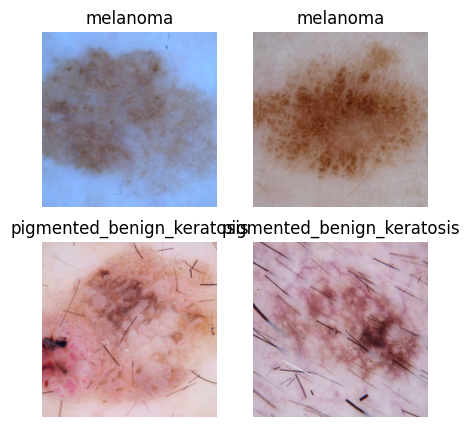

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# class_name对应label，按文件夹字符串从小到大的顺序标记label
class_name = {
    0: "basal_cell_carcinoma",
    1: "melanoma",
    2: "nevus",
    3: "pigmented_benign_keratosis",
}

# print(images[0])
plt.figure(figsize=(5, 5))
for i in range(4):
    # 获取图像及其对应的label
    # print(images[i])
    data_image = images[i].asnumpy()
    data_label = labels[i]
    # 处理图像供展示使用
    data_image = np.transpose(data_image, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data_image = std * data_image + mean
    data_image = np.clip(data_image, 0, 1)
    # 显示图像
    plt.subplot(2, 2, i+1)
    plt.imshow(data_image)
    plt.title(class_name[int(labels[i].asnumpy())])
    plt.axis("off")

plt.show()

## 3 模型训练
### 3.1 网络搭建

在MindSpore中构建和配置深度残差网络，用于图像识别等任务，通过代码定义一个基于MindSpore框架的ResNet（残差网络）模型，包括基本的残差块（ResidualBlockBase和ResidualBlock）和完整的ResNet类；

提供_resnet和resnet50函数来实例化ResNet模型，加载预训练权重；

In [10]:
from typing import Type, Union, List, Optional
from mindspore import nn, train
from mindspore.common.initializer import Normal


weight_init = Normal(mean=0, sigma=0.02)
gamma_init = Normal(mean=1, sigma=0.02)
class ResidualBlockBase(nn.Cell):
    expansion: int = 1  # 最后一个卷积核数量与第一个卷积核数量相等

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            self.norm = nn.BatchNorm2d(out_channel)
        else:
            self.norm = norm

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.conv2 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, weight_init=weight_init)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        """ResidualBlockBase construct."""
        identity = x  # shortcuts分支

        out = self.conv1(x)  # 主分支第一层：3*3卷积层
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)
        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out
class ResidualBlock(nn.Cell):
    expansion = 4  # 最后一个卷积核的数量是第一个卷积核数量的4倍

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=1, weight_init=weight_init)
        self.norm1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.norm2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(out_channel, out_channel * self.expansion,
                               kernel_size=1, weight_init=weight_init)
        self.norm3 = nn.BatchNorm2d(out_channel * self.expansion)

        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):

        identity = x  # shortscuts分支

        out = self.conv1(x)  # 主分支第一层：1*1卷积层
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv3(out)  # 主分支第三层：1*1卷积层
        out = self.norm3(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)

        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out
def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts分支


    if stride != 1 or last_out_channel != channel * block.expansion:

        down_sample = nn.SequentialCell([
            nn.Conv2d(last_out_channel, channel * block.expansion,
                      kernel_size=1, stride=stride, weight_init=weight_init),
            nn.BatchNorm2d(channel * block.expansion, gamma_init=gamma_init)
        ])

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample))

    in_channel = channel * block.expansion
    # 堆叠残差网络
    for _ in range(1, block_nums):

        layers.append(block(in_channel, channel))

    return nn.SequentialCell(layers)
from mindspore import load_checkpoint, load_param_into_net


class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], num_classes: int, input_channel: int) -> None:
        super(ResNet, self).__init__()

        self.relu = nn.ReLU()
        # 第一个卷积层，输入channel为3（彩色图像），输出channel为64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, weight_init=weight_init)
        self.norm = nn.BatchNorm2d(64)
        # 最大池化层，缩小图片的尺寸
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # 各个残差网络结构块定义，
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)
        # 平均池化层
        self.avg_pool = nn.AvgPool2d()
        # flattern层
        self.flatten = nn.Flatten()
        # 全连接层
        self.fc = nn.Dense(in_channels=input_channel, out_channels=num_classes)

    def construct(self, x):

        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x


def _resnet(model_url: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, pretrianed_ckpt: str,
            input_channel: int):
    model = ResNet(block, layers, num_classes, input_channel)

    if pretrained:
        # 加载预训练模型
        download(url=model_url, path=pretrianed_ckpt, replace=True)
        param_dict = load_checkpoint(pretrianed_ckpt)
        load_param_into_net(model, param_dict)

    return model


def resnet50(num_classes: int = 1000, pretrained: bool = False):
    "ResNet50模型"
    resnet50_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/models/application/resnet50_224_new.ckpt"
    resnet50_ckpt = "./pretrainmodel/resnet50_224_new.ckpt"
    return _resnet(resnet50_url, ResidualBlock, [3, 4, 6, 3], num_classes,
                   pretrained, resnet50_ckpt, 2048)

### 3.2 模型训练

使用MindSpore框架在NPU上训练一个自定义的ResNet50模型，该模型被修改为用于一个4类的分类任务；

定义优化器、损失函数和评估指标，实例化训练模型，选择最佳准确率以及最佳模型检查点路径保存；

    --------------------
    Epoch: [ 23/ 25], Average Train Loss: [0.418], Accuracy: [0.734]
    epoch time: 4133.578 ms, per step time: 158.984 ms
    --------------------
    Epoch: [ 24/ 25], Average Train Loss: [0.448], Accuracy: [0.719]
    epoch time: 3491.099 ms, per step time: 134.273 ms
    --------------------
    Epoch: [ 25/ 25], Average Train Loss: [0.390], Accuracy: [0.719]
    epoch time: 3515.689 ms, per step time: 135.219 ms
    ================================================================================
    End of validation the best Accuracy is:  0.734, save the best ckpt file in ./BestCheckpoint/resnet50-best.ckpt

In [11]:
# 代码中首先导入了必要的MindSpore模块和函数，并设置了运行环境。
import mindspore
from mindspore import nn, train
from mindspore.nn import Loss, Accuracy
!pip install download
import mindspore as ms
from download import download

network = resnet50(pretrained=True)

# 通过替换ResNet50的原始全连接层和平均池化层来适配新的任务
# 全连接层输入层的大小
in_channels = network.fc.in_channels
# 输出通道数大小为皮肤肿瘤分类数4
head = nn.Dense(in_channels, 4)
# 重置全连接层
network.fc = head

# 平均池化层kernel size为7
avg_pool = nn.AvgPool2d(kernel_size=7)
# 重置平均池化层
network.avg_pool = avg_pool

import mindspore as ms
import mindspore

# 定义优化器和损失函数
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=momentum)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 实例化模型
model = train.Model(network, loss_fn, opt, metrics={"Accuracy": Accuracy()})

def forward_fn(inputs, targets):

    logits = network(inputs)
    loss = loss_fn(logits, targets)

    return loss

grad_fn = mindspore.ops.value_and_grad(forward_fn, None, opt.parameters)

def train_step(inputs, targets):

    loss, grads = grad_fn(inputs, targets)
    opt(grads)

    return loss
    
# 创建迭代器
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
# 最佳模型保存路径
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/resnet50-best.ckpt"
import os
import time

# 开始循环训练
print("Start Training Loop ...")

best_acc = 0

# 训练循环中，数据通过迭代器被加载，模型在每个epoch中更新权重，并计算训练损失。
# 在每个epoch结束时，模型在验证集上评估准确率，并保存具有最高准确率的模型检查点。
for epoch in range(num_epochs):
    losses = []
    network.set_train()

    epoch_start = time.time()

    # 为每轮训练读入数据
    for i, (images, labels) in enumerate(data_loader_train):
        labels = labels.astype(ms.int32)
        loss = train_step(images, labels)
        losses.append(loss)

    # 每个epoch结束后，验证准确率

    acc = model.eval(dataset_val)['Accuracy']

    epoch_end = time.time()
    epoch_seconds = (epoch_end - epoch_start) * 1000
    step_seconds = epoch_seconds/step_size_train

    print("-" * 20)
    print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
        epoch+1, num_epochs, sum(losses)/len(losses), acc
    ))
    print("epoch time: %5.3f ms, per step time: %5.3f ms" % (
        epoch_seconds, step_seconds
    ))

    if acc > best_acc:
        best_acc = acc
        if not os.path.exists(best_ckpt_dir):
            os.mkdir(best_ckpt_dir)
        ms.save_checkpoint(network, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

file_sizes: 100%|█████████████████████████████| 102M/102M [00:00<00:00, 154MB/s]
Successfully downloaded file to ./pretrainmodel/resnet50_224_new.ckpt
Start Training Loop ...
..

/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[32, 2147483647], [2048, 2048], [7, 15], [7, 15]] to [[32, 2147483647], [2048, 2048], [7, 15], (7, 15)].
  warnings.warn(to_print)


.......--------------------
Epoch: [  1/ 25], Average Train Loss: [1.354], Accuracy: [0.328]
epoch time: 101886.654 ms, per step time: 3918.717 ms
--------------------
Epoch: [  2/ 25], Average Train Loss: [1.263], Accuracy: [0.406]
epoch time: 3997.367 ms, per step time: 153.745 ms
--------------------
Epoch: [  3/ 25], Average Train Loss: [1.155], Accuracy: [0.391]
epoch time: 3834.136 ms, per step time: 147.467 ms
--------------------
Epoch: [  4/ 25], Average Train Loss: [1.055], Accuracy: [0.484]
epoch time: 3880.164 ms, per step time: 149.237 ms
--------------------
Epoch: [  5/ 25], Average Train Loss: [0.970], Accuracy: [0.453]
epoch time: 3686.648 ms, per step time: 141.794 ms
--------------------
Epoch: [  6/ 25], Average Train Loss: [0.893], Accuracy: [0.484]
epoch time: 3704.433 ms, per step time: 142.478 ms
--------------------
Epoch: [  7/ 25], Average Train Loss: [0.830], Accuracy: [0.500]
epoch time: 3650.135 ms, per step time: 140.390 ms
--------------------
Epoch: [  

### 3.3 模型评估

 从验证数据集中提取了一批次的数据，使用模型进行预测，并根据预测结果将图像及其预测标签以蓝色（正确）或红色（错误）显示。
 
 使用matplotlib库绘制了一个包含四个子图的图像，每个子图展示了一张图像及其预测结果。

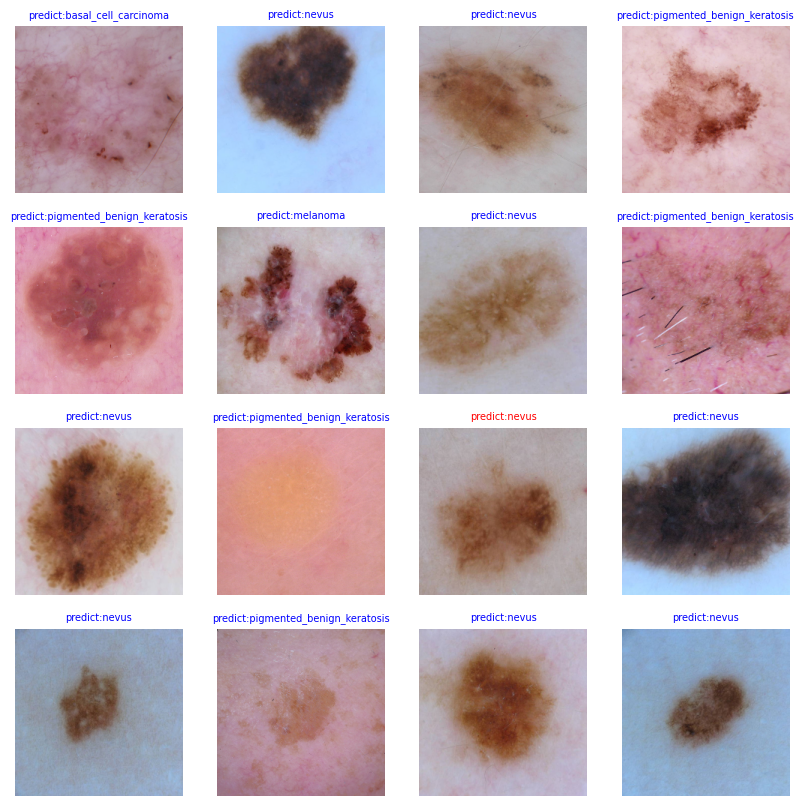

In [12]:
import matplotlib.pyplot as plt
import mindspore as ms

def visualize_model(best_ckpt_path, val_ds):
    net = resnet50()
    # 全连接层输入层的大小
    in_channels = net.fc.in_channels
    # 输出通道数大小为分类数4
    head = nn.Dense(in_channels, 4)
    # 重置全连接层
    net.fc = head
    # 平均池化层kernel size为7
    avg_pool = nn.AvgPool2d(kernel_size=7)
    # 重置平均池化层
    net.avg_pool = avg_pool
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    model = train.Model(net)
    # 加载验证集的数据进行验证
    data = next(val_ds.create_dict_iterator())
    images = data["image"].asnumpy()
    # print(type(images))
    # print(images.shape)
    #print(images)
    labels = data["label"].asnumpy()
    #print(labels)
    class_name = {
        0: "basal_cell_carcinoma",
        1: "melanoma",
        2: "nevus",
        3: "pigmented_benign_keratosis"
    }

    # 预测图像类别
    data_pre=ms.Tensor(data["image"])
    # print(data_pre.shape)
    # print(type(data_pre))
    output = model.predict(data_pre)

    # print(output)
    pred = np.argmax(output.asnumpy(), axis=1)

    # 显示图像及图像的预测值
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}'.format(class_name[pred[i]]), color=color,fontsize=7)
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()
visualize_model('BestCheckpoint/resnet50-best.ckpt', dataset_val)

## 4 推理使用 

(1, 3, 224, 224)
<class 'mindspore.common.tensor.Tensor'>


/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[1, 1], [2048, 2048], [7, 15], [7, 15]] to [[1, 1], [2048, 2048], [7, 15], (7, 15)].
  warnings.warn(to_print)


.[[-2.936149    0.86078197  2.3170192  -1.0823358 ]]
[2]


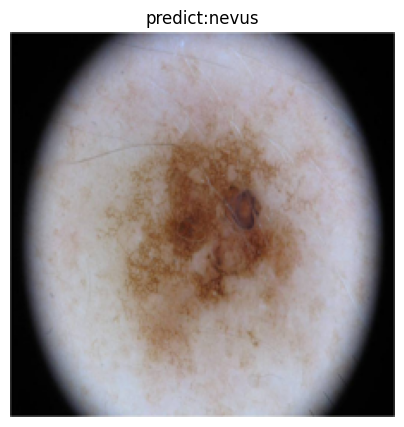

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import mindspore as ms
from mindspore import nn
from mindspore.train.serialization import load_checkpoint, load_param_into_net
import mindspore.numpy as mnp

def preprocess_image(image_path):
    # 使用PIL加载图像
    from PIL import Image
    image = Image.open(image_path)
    # 转换图像为RGB模式
    image = image.convert('RGB')
    # 调整图像大小以匹配模型输入
    image = image.resize((224, 224))  # 假设模型输入大小为224x224
    # 将图像转换为numpy数组
    image_array = np.array(image)
    # 归一化图像数组
    image_array = image_array / 255.0
    image_array = np.transpose(image_array, (2, 0, 1))
    # 扩展维度以匹配模型输入，例如 (1, 3, 224, 224)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array.astype(np.float32)  # 确保数据类型为float32

def visualize_prediction(image_path, best_ckpt_path):
    net = resnet50()
    # 全连接层输入层的大小
    in_channels = net.fc.in_channels
    # 输出通道数大小为分类数4
    head = nn.Dense(in_channels, 4)
    # 重置全连接层
    net.fc = head
    # 平均池化层kernel size为7
    avg_pool = nn.AvgPool2d(kernel_size=7)
    # 重置平均池化层
    net.avg_pool = avg_pool
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    model = train.Model(net)
    # 预处理图像
    image = preprocess_image(image_path)
    data_pre = ms.Tensor(image)
    print(data_pre.shape)
    print(type(data_pre)) 
    class_name = {
        0: "basal_cell_carcinoma",
        1: "melanoma",
        2: "nevus",
        3: "pigmented_benign_keratosis"
    }
    output = model.predict(data_pre)
    print(output)
    pred = np.argmax(output.asnumpy(), axis=1)
    print(pred)

    plt.figure(figsize=(5, 5))
    plt.subplot(1, 1, 1)
    plt.title('predict:{}'.format(class_name[pred[0]]))
    picture_show = image[0]  # 已经是归一化后的图像
    picture_show = np.transpose(picture_show, (1, 2, 0))  # 转换为(224, 224, 3)
    plt.imshow(picture_show)
    plt.axis('off')
    plt.show()

# 调用函数，传入图片路径和模型检查点路径
visualize_prediction('pifudata_Maker/images/val/2/ISIC_0000005.jpg', 'BestCheckpoint/resnet50-best.ckpt')